# Download, read and plot SMAP data with xarray and rioxarray

## Overview

### Introduction

This notebook demonstrates searching for, downloading, reading and plotting SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture data using `earthaccess`, `xarray` and `cartopy`.  `earthaccess` makes searching for and downloading NASA Earth science data easy.  `xarray` is a commonly used, high-level package for working with n-dimensional gridded data.  It makes reading HDF5 data easy and simplifies common Earth and atmospheric science workflows.  `cartopy` provides a simple plotting interface to display geospatial data and create maps complete with country, state and outher topographic features.  Finally, we demonstrate how to transform and resample the data using `rioxarray`, an add-on for `xarray` that brings many of the geospatial functions from `rasterio` to n-dimensional data.

To enable any of these functions `xarray.Datasets`, one of the two data structures used in `xarray`, `rioxarray.Datasets` expect to have information about the coordinate reference system (CRS), also known as the spatial reference system (SRS), and the coordinate system of the grid.  Many datasets that conform to CF-Conventions already contain this information.  Unfortunately, the SMAP data files do not contain this information.  The tutorial shows how to add this information.  It also shows how to fix some other issues with the data.

These issues are common to many datasets.  These sections of the tutorial can be thought of as a guide to working with and fixing datasets with missing or inadequate metadata.

>The purpose of the CF conventions is to require conforming datasets to contain sufficient metadata that they are self-describing in the sense that each variable in the file has an associated description of what it represents, including physical units if appropriate, and that each value can be located in space (relative to earth-based coordinates) and time.
>
>An important benefit of a convention is that it enables software tools to display data and perform operations on specified subsets of the data with minimal user intervention. It is possible to provide the metadata describing how a field is located in time and space in many different ways that a human would immediately recognize as equivalent. The purpose in restricting how the metadata is represented is to make it practical to write software that allows a machine to parse that metadata and to automatically associate each data value with its location in time and space. It is equally important that the metadata be easy for human users to write and to understand.

The tutorials use the SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 8 (SPL3SMP, DOI:10.5067/OMHVSRGFX38O).

[Data set landing page](https://nsidc.org/data/spl3smp/versions/8)  
[User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf)


### Learning Goals

By the end of this tutorial you will know how to:
1. open the SMAP data with `xarray`;
2. add CRS and coordinate system information;
3. fix metadata issues with dataset;
4. plot the data on a map;
5. transform and resample the data to a new CRS.


### Prerequisites
1. You will need an Earthdata login to download the data.
2. You will need to have created and activated the `smap-tutorials` environment.

## Tutorial

### Import libraries

We'll be using tools from the following libraries.

In [1]:
from pathlib import Path  # for working with paths on the local file system
from pprint import pprint  # for nice printing

# For data search and download
import earthaccess

# For reading and working with the data
import rioxarray
import xarray as xr
import numpy as np
import h5py

# For defining CRS and coordinate system
from affine import Affine
from pyproj import CRS

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Search for SMAP data

We will use `earthaccess` to search for SMAP Level 3 files for March 2017.  The first step is to authenticate using `earthaccess.login`.  We can then use `search_data` to search for data.

In [2]:
auth = earthaccess.login()

In [3]:
results = earthaccess.search_data(
    short_name = 'SPL3SMP',
    version = '008',
    cloud_hosted = False,
    temporal = ('2017-03-01','2017-03-31')
)

## Download files

If you haven't already, we'll download the files to a local directory.  This is defined in the `DOWNLOAD_PATH` constant.  In this example, we'll use the `Path` object from the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package to build a path to a directory `smap_data` under the current working directory.  `Path` objects have methods to return the current working directory `.cwd()`, make directories `.mkdir()`, and search using [glob patterns](https://en.wikipedia.org/wiki/Glob_(programming)) `.glob()`.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to download files to a different directory change the cell below to  

```
DOWNLOAD_PATH = Path("path-to-download-directory")
```
</div>

`earthaccess.download` checks if the files already exist in the local download directory.  If they do, they will not be downloaded.

In [4]:
DOWNLOAD_PATH = Path.cwd() / "smap_data"
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)  # creates parents if they don't exist and fails silently if path exists

smap_files = earthaccess.download(results, str(DOWNLOAD_PATH))

'NoneType' object has no attribute 'get': You must call earthaccess.login() before you can download data


We can use `.glob('*.h5')` to get a list of SMAP files in the `DOWNLOAD_PATH`.  `glob` returns a python generator object.  If we want to see the filepaths we can pass this object to the `list()` method, which converts the generator to a list.

In [5]:
smap_files = list(DOWNLOAD_PATH.glob('*.h5'))
smap_files

[PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170327_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170330_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170309_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170323_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170324_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170320_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170319_R18290_001.h5'),
 PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170304_R18290_001.h5'),
 PosixPath('/Users/roma8

## Create a georeferenced `xarray.Dataset` for a subset of variables from an HDF5 SMAP file

Georeferenced data sets are required for Earth science analysis workflows.  This may be as simple as plotting a map.  You may want to transform the data so it can be used with another data set, or you may want to perform some spatial subsetting.  Each of these tasks requires that the coordinate system of the dataset is known and that there is sufficient information to relate the coordinate system to an actual location on the Earth.  The coordinate system may be spherical (_latitude_ and _longitude_) or cartesian (_x_ and _y_), and it may include a _height_ component (sometimes _z_ or atmospheric _level_).  _latitude_, _longitude_ and _height_, and _x_, _y_, and _z_ represent the dimensions of the dataset.  Other non-geospatial dimensions may also be included.  The relationship between the coordinate system and a location on the Earth is defined by the coordinate reference system (CRS), sometimes called a spatial reference system (SRS).  This includes a reference ellipsoid and datum, and, if the data are in a projected coordinate system, information about the projection method and projection parameters.  Ideally, this information is included in the data file so that software tools can use this information directly to plot and manipulate the data. Including this information in files also makes it very easy for users to undertsand the data.

The SMAP HDF5 data files do not contain sufficient information to geolocate data on the Earth surface.  We need to add this information so that we can work with the data in `xarray`.  We also need to make some changes to how missing data is represented, as well as change some of the attribute values.  In the following sections we will:

1. read a subset of `Datasets` (variables) from the HDF5 file;
2. add meaning dimension names;
3. mask missing data;
4. add coordinate information to the dataset;
5. add a coordinate reference system information the dataset.

#### Read the data

HDF5 files are organized into _groups_.  These groups can contain  sub-_groups_ or _datasets_.  This is similar to the directory structure on your local filesystem that is organized into directories, sub-directories and files.  The top group is called the _root_ group.  The SMAP L3 files contain three groups.

```
root  
  |- Metadata  
  |- Soil_Moisture_Retrieval_Data_AM  
  |- Soil_Moisture_Retrieval_Data_PM  
```

<div class="alert alert-block alert-info">
<b>Note:</b> You can find out how an HDF5 file is structured, what groups exist, and what variables the file contains using tools like `h5dump`, online HDF5 viewers like [MyHDF5](https://myhdf5.hdfgroup.org/help), or lower level python tools like h5py.
</div>

`xarray` can only read one group at a time from an HDF5 file.  Multiple groups can be read with multiple reads and then concatenate the `xarray.Datasets`.  See xarray tricks for HDF5 data [To be added].  Or you can use the [`xarray-datatree`](https://xarray-datatree.readthedocs.io/en/stable/) package.

In the following example, we read only the `Soil_Moisture_Retrieval_Data_AM` group.  This is done by passing the group name using the `group` keyword.  If you wanted data for a subgroup or a dataset one or more levels down, the argument passed to `group` would look like a filepath; for example `"group/subgroup/dataset"`.

In [6]:
gds = xr.open_dataset(smap_files[0], group='Soil_Moisture_Retrieval_Data_AM', phony_dims='sort')  #, decode_coords='all', decode_cf=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (phony_dim_0: 406, phony_dim_1: 964,
                                  phony_dim_2: 3)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/53)
    EASE_column_index            (phony_dim_0, phony_dim_1) float32 2MB ...
    EASE_row_index               (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo                       (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_dca                   (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scah                  (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scav                  (phony_dim_0, phony_dim_1) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity           (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_dca       (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scah      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scav      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_water_content     (phony_dim_0, phony_dim_1) float32 2MB ...

In [7]:
smap_files[0]

PosixPath('/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170327_R18290_001.h5')

#### Add meaningful dimension names

53 variables are loaded from `Soil_Moisture_Retrieval_Data_AM`.  However, we can immediately see some issues.  The dimensions are named `phony_dim_0`, `phony_dim_1`, and `phony_dim_2`, which is not much help.  This is because no dimensions are assigned to Datasets, so `xarray` has to generate some dummy variables.
 
We'll change the names of the dimensions to something meaningful.  First, we need figure out what the dimensions are.  This is more diffcult than is should be and requires some data sleuthing and assumptions.  The description of the `landcover_class` offers some information, albeit misleading, but it is a clue.

> An enumerated type that specifies the most common landcover class in the grid cell based on the IGBP landcover map. The array order is longitude (ascending), followed by latitude (descending), and followed by IGBP land cover type descending dominance (only the first three types are listed)

This description states that the dimensions of the landcover_class array are longitude, latitude and IGBP land cover class.  The data are in projected coordinates (the EASE Grid 2.0 Global) **so longitude and latitude cannot be dimensions**.  Longitude and latitude in projected coordinate systems must be 2D arrays.  For projected coordinate systems, coordnates are usually x and y, or easting and northing.  From the user guide, we also know that the data are on a grid with 964 columns and 406 rows, and cells that have a nominal cell-size of 36 km by 36 km.  Based on this information we can assume that `phony_dim_0` is the y-dimension and `phony_dim_1` is the x-dimension in cartesian coordinates.  The 3rd dimension (`phoney_dim_2`) appears to be land cover class.  We can lot the data to confirm that this at least looks correct.  

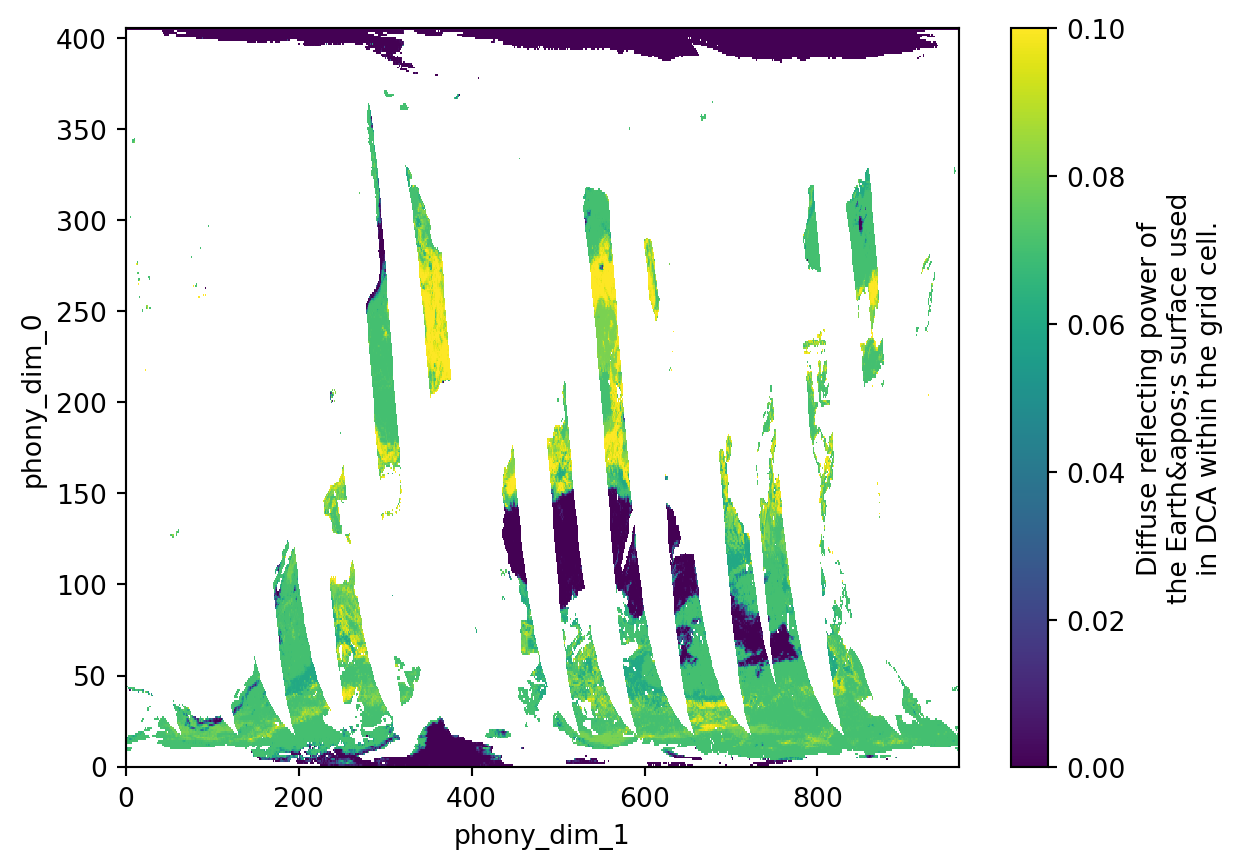

In [8]:
gds.albedo.plot()

Apart from looking like the data is upside down, our assumptions about `x` and `y` look to be correct.  So we'll rename the coordinates:

 - `phony_dim_0 --> y`
 - `phony_dim_1 --> x`
 - `phony_dim_2 --> igbp_class`

We can do this using `rename_dims`, which takes a dictionary as an argument, where keys are the old dimension name and values are the new dimension name.

In [9]:
gds = gds.rename_dims({'phony_dim_0': 'y', 'phony_dim_1': 'x', 'phony_dim_2': 'igbp_class'})
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Dimensions without coordinates: y, x, igbp_class
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

#### Add coordinate variables

[Coordinate variables](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#coordinate-types) locate the data in space and time.  Each coordinate variable is a 1-dimensional array associated with a single dimension, usually with the same name as that dimension, and has the same size as that dimensions.  Values for coordinate variables give the position of each grid cell within the dataset's coordinate system.  Two-dimensional _auxillary coordinates_ are also allowed.  These _auxillary coordinates_ need to be related to data variables by including a `coordinates` attribute that lists the _auxillary coordinates_.  Coordinate variables are not allowed to have missing values.  However, _auxillary coordinates_ can have missing values.

The SMAP data contain 2-dimensional `latitude` and `longitude` grids but data variables do not have a `coordinates` attribute.  The data do not contain coordinate variables.  Coordinate variables allow efficient subsetting, as well as plotting and transformation.  So we need to add `x` and `y` as coordinates.  

Because `latitude` and `longitude` are likely coordinate variables, we'll plot them. 

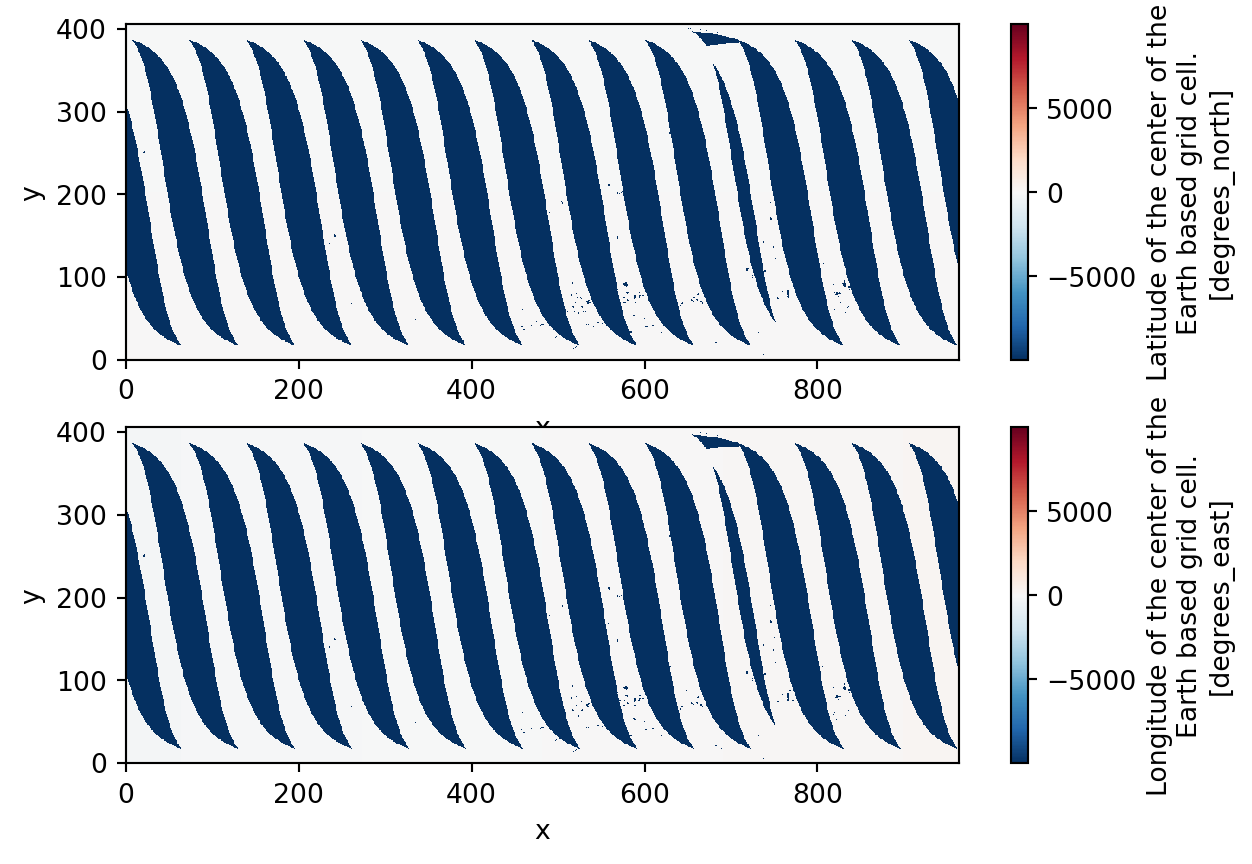

In [10]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0])
gds.longitude.plot(ax=ax[1])

This looks a little strange.  Printing minima and maxima for `latitude` and `longitude`, shows that both values are outside of the expected ranges: -90 to 90 for `latitude`, and -180 to 180 or 0 to 360 for `longitude`.

In [11]:
print(f"Latitude:  Min = {gds.latitude.min().values}, Max = {gds.latitude.max().values}")
print(f"Longitude: Min = {gds.longitude.min().values}, Max = {gds.longitude.max().values}")

Latitude:  Min = -9999.0, Max = 83.63197326660156
Longitude: Min = -9999.0, Max = 179.8132781982422


If we plot both latitude and soil_moisture, we can see that latitude values have been masked with -9999. where there are no valid data values.  **This is not a good or sensible approach because latitude and longitude are coordinates.  As long as latitude and longitude values are between -90 and 90, and -180 and 180 (or 0 and 360), they are valid coordinates.  While missing values are allowed for _auxillary coordinates_, coordinate values should not have missing values.  We also need coordinates for all grid cells for plotting and other operations.** 

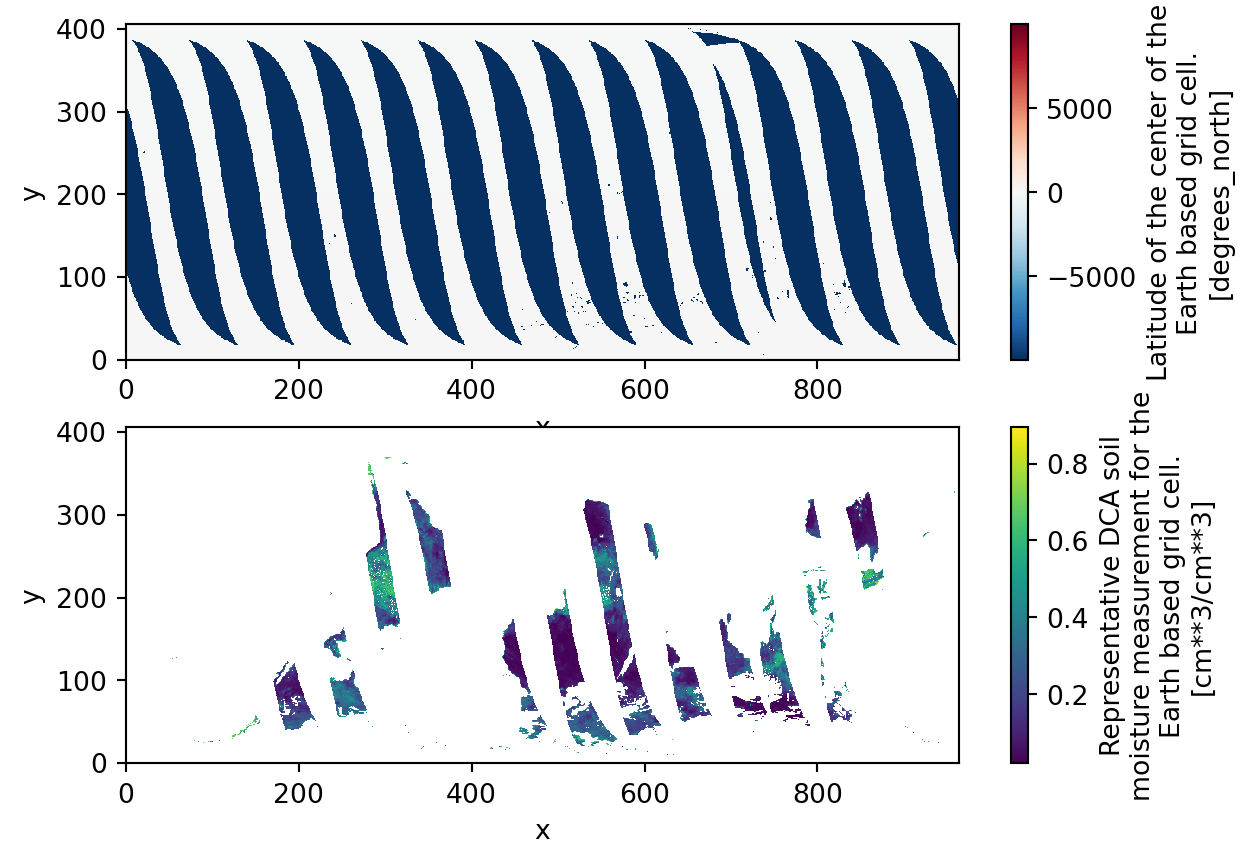

In [12]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0]);
gds.soil_moisture.plot(ax=ax[1])

Neither the plot of latitude nor the minimum and maximum values look as we would expect.  We expect latitude to be in the range of -90 to +90.  The maximum is actually in this range but the minimum is -9999., which is suspiciously like a `_FillData` or missing data value.  We would also expect the image to show a smooth field that only varies in the vertical direction, e.g. from -90. to 90. or some similar range.  Instead it shows a set of lozenges.

Let's set the `_FillValue` attribute for latitude to `-9999`.  In `xarray`, we have to use `where` to apply a mask everywhere a condition is not `True`.  Here we set the condition to be _not equal to -9999._  To save time and errors later, we also set the `encoding` entry for `fillvalue` to -9999.

<div class="alert alert-block alert-warning">
`encoding` is a dictionary of parameters that defines how data are "encoded" in the file.  It includes information about how data are compressed, chunked, the _FillValue, and data type.  Saving the `encoding` is not strictly necessary unless you want to write the data to a new file.  We'll follow these steps here to demonstrate how to preserve the encoding data. 
</div>

In [13]:
print(gds.latitude.encoding)

{'chunksizes': (1, 964), 'fletcher32': False, 'shuffle': False, 'preferred_chunks': {'phony_dim_0': 1, 'phony_dim_1': 964}, 'zlib': True, 'complevel': 2, 'source': '/Users/roma8902/projects/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170327_R18290_001.h5', 'original_shape': (406, 964), 'dtype': dtype('<f4')}


In [14]:
fillvalue = -9999.

# `where` does not preserve encoding, so we have to copy first
encoding = gds.latitude.encoding
# Apply fillvalue mask
gds['latitude'] = gds.latitude.where(gds.latitude != fillvalue)
# we copy the encoding back to DataArray
gds.latitude.encoding = encoding
# ...and update encoding to include fillvalue
gds.latitude.encoding['fillvalue'] = fillvalue

# ...and for longitude
encoding = gds.longitude.encoding
gds["longitude"] = gds.longitude.where(gds.longitude != fillvalue)
gds.longitude.encoding = encoding
gds.longitude.encoding["fillvalue"] = fillvalue
                                       

Now when we check the range of the latitude values, we see that the range is between -83.63... and 83.63... as we expect.

In [15]:
print(f"Latitude:  Min = {gds.latitude.min().values}, Max = {gds.latitude.max().values}")
print(f"Longitude: Min = {gds.longitude.min().values}, Max = {gds.longitude.max().values}")

Latitude:  Min = -83.63197326660156, Max = 83.63197326660156
Longitude: Min = -179.8132781982422, Max = 179.8132781982422


Plotting the data again, we see that latitude values are within the expected range but that hasn't solved the missing data problem.

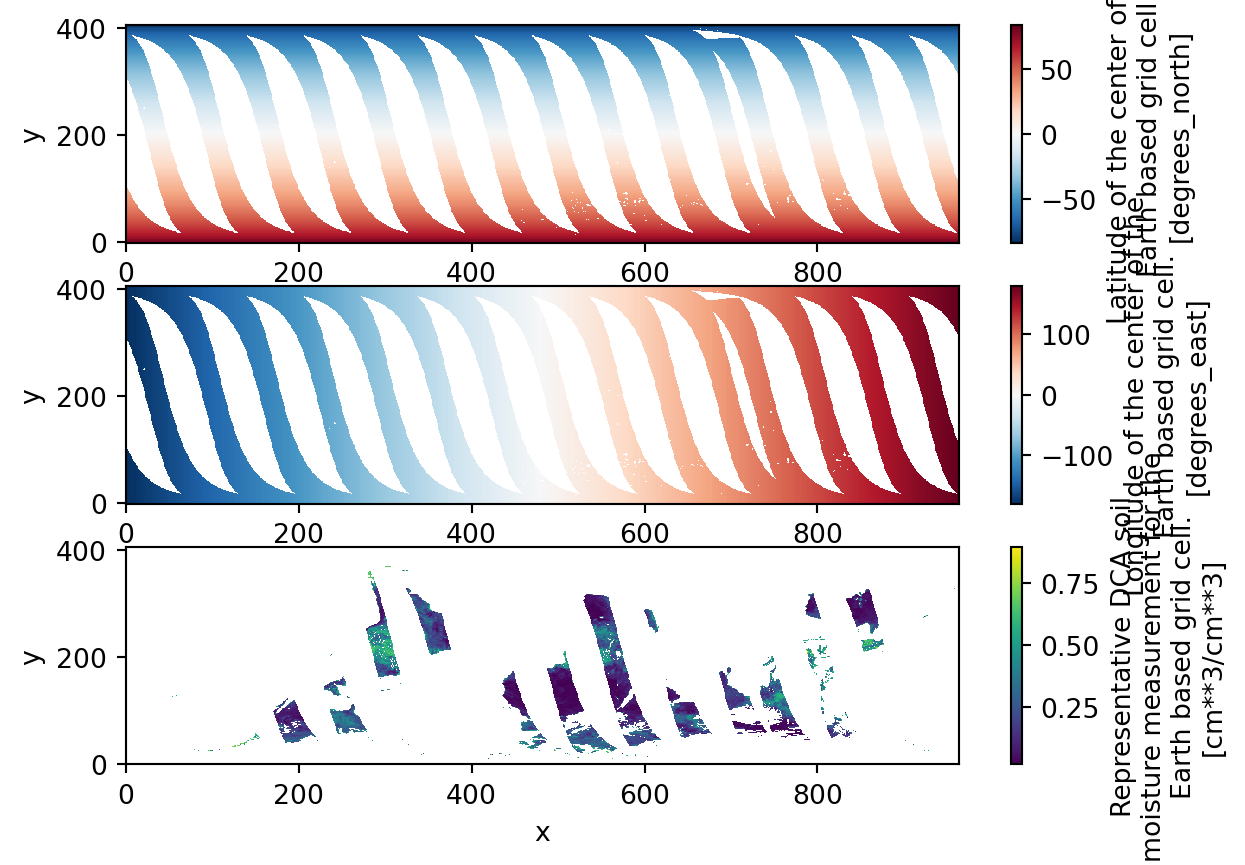

In [16]:
fig, ax = plt.subplots(3, 1)
gds.latitude.plot(ax=ax[0]);
gds.longitude.plot(ax=ax[1]);
gds.soil_moisture.plot(ax=ax[2])

#### Adding x and y coordinates

Missing values for latitude and longitude can cause problems for plotting and other operations.  As noted above, the files do not include complete information about the coordinate reference system or the grid definition.  So we need to do some data sleuthing.

Tables 4 and 5 in the [User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf) provide geospatial information.  Further information on EASE Grids can be found on [A Guide to EASE Grids page](https://nsidc.org/data/user-resources/help-center/guide-ease-grids).

<div class="alert alert-block alert-warning">
<b>Note:</b> The ATBD for the L3 SMP data gives the data array dimensions as 406 x 963.
</div>



The CRS and grid definition are independent.  The CRS defines how projected coordinates, usually in meters, relate to geographic latitude and longitude.  The grid definition relates how image coordinates (columns and rows) map to the projected coordinates.  The Guide to EASE Grids has 8 grid definitions, ranging from 1 km to 36 km cell sizes, for the Global EASE-Grid 2.0 CRS (EPSG:9633).  We could define many more grid definitions.  For more information on CRS, map projections and grids see [_Link to be added_]().

In the [table](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-10) for the 36 km Global EASE-Grid 2.0 we are given the height and width of each grid cell, and the x and y coordinates of the upper-left corner of the upper-left grid cell.  We can see that the 36 km grid cell size is not exact.  In fact the value the table gives is not exact.  The actual value runs to 9 decimal places.  This is because the grid cell height and width of the global grid were defined so that an exact number of cells span the equator {@brodzik_ease}.  This is not necessary for polar grids.

<div class="alert alert-block alert-info">
<b>Tip:</b> Exact definitions of CRS, projection and grid parameters can be found in the Grid Parameter Definition (gpd) files in the [`mapxmaps` GitHub repository](https://github.com/nsidc/mapxmaps).  These gpd files have a somewhat esoteric format, so might take a little bit to understand.  It is important that the grid definition is exact because we cannot merge datasets if the coordinates do not match, even to the 9th decimal place.
</div>

In [17]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

The projected coordinates of a grid cell can be found using the following formulas:

$$
x = (grid\_cell\_width \times row) + x\_upper\_left\_corner
$$
$$
y = (grid\_cell\_height \times column) + y\_upper\_left\_corner)
$$

This equations assumes that the origin of the image coordinates start at row=0. and column=0. in the upper-left corner of the upper-left grid cell.  So the center of the upper-left grid cell is row=0.5 and column=0.5.  Adding 0.5 to row and column indices solves this problem.

We could write a function to return (x, y) coordinates for (column, row) image coordinates using the equations above.  Or we can use the `Affine` class from the `affine` package to define an affine matrix.  This is what we'll do below.  

In [18]:
transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)
transform

Affine(36032.220840584, 0.0, -17367530.4451615,
       0.0, -36032.220840584, 7314540.8306386)

This then allows us to calculate x and y coordinates from column and row indices using matrix multiplication.

In [19]:
transform * (964, 406)

(17367530.445161477, -7314540.830638505)

We'll define vectors for the row and column indices of the grid cell centers, and then use the `transform` matrix to get x and y coordinates.  These only need to be vectors as well because each column will have the same row indices and each row will have the same column indices. We'll use the `numpy.arange` function to do and start the range at 0.5 to offset the row and column indices for grid cell centers by 0.5.

In [20]:
nrows, ncolumns, nclass = gds.dims['y'], gds.dims['x'], gds.dims['igbp_class']  #data_vars['soil_moisture'][1].shape
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)  # Add attributes

/var/folders/3n/jlwg76x96d92k9ttmpcq8gt00000gs/T/ipykernel_60006/13705710.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nrows, ncolumns, nclass = gds.dims['y'], gds.dims['x'], gds.dims['igbp_class']  #data_vars['soil_moisture'][1].shape


We need to assign `x`, `y`, and `igbp_class` as coordinates.  This should be sufficient for plotting.  However, if we want to reproject the data we should define the CRS and spatial coordinates, and transform.  We do this using `rioxarray` accessors.

In [21]:
gds = gds.assign_coords(x=x, y=y, igbp_class=igbp_class)

gds.rio.write_crs(6933, grid_mapping_name='wgs84_easegrid2_global', inplace=True)
gds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
gds.rio.write_coordinate_system(inplace=True)
gds.rio.write_transform(transform)
gds.rio.write_grid_mapping('wgs84_easegrid2_global', inplace=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 24B 0 1 2
    wgs84_easegrid2_global       int64 8B 0
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

In [22]:
print(gds.latitude.rio.grid_mapping)
print(gds.rio.bounds())

wgs84_easegrid2_global
(-17367530.4451615, -7314540.830638505, 17367530.445161473, 7314540.8306386)


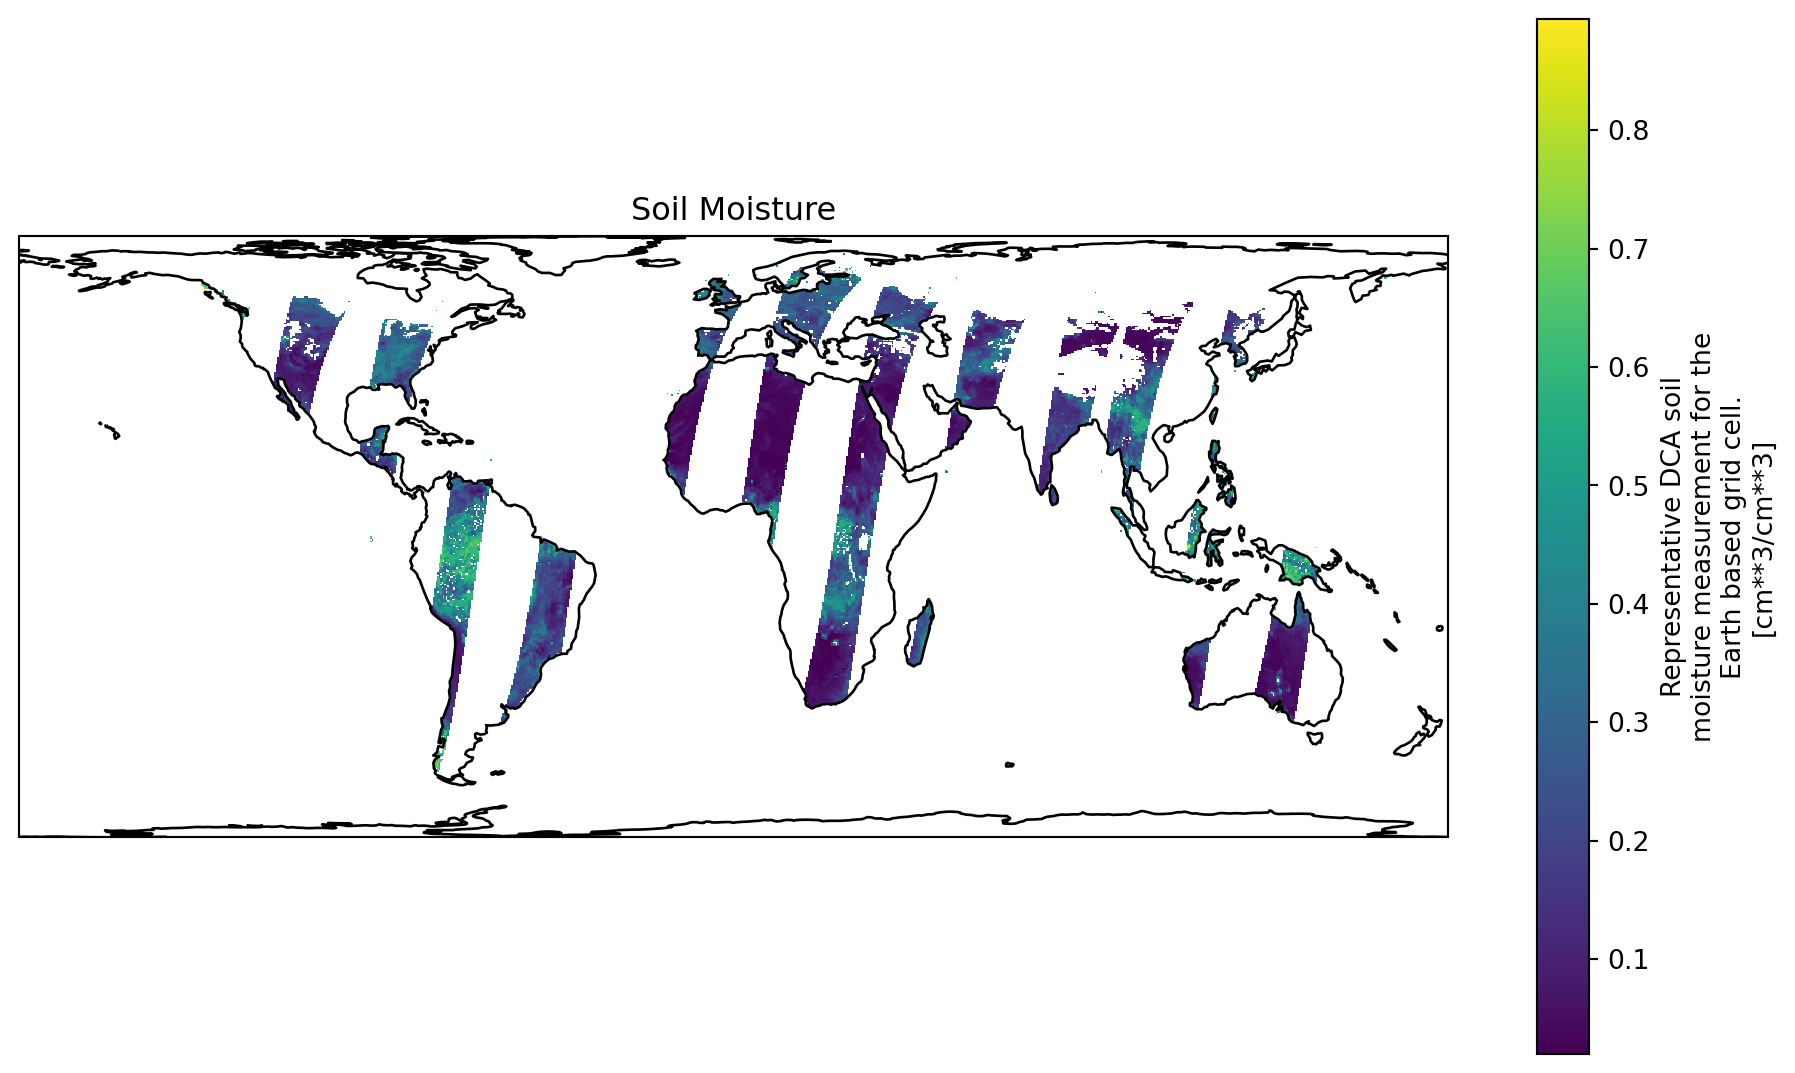

In [23]:
EASEGrid2 = ccrs.epsg(gds.rio.crs.to_epsg())

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection=EASEGrid2)

ax.coastlines()
gds.soil_moisture.plot(ax=ax,)
ax.set_title('Soil Moisture');

## Extra Stuff to be refined

In [24]:
grid_mapping_name = "WGS84_NSIDC_EASEGrid_2.0_Global"
datasets = ['Soil_Moisture_Retrieval_Data_AM/soil_moisture', 'Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag']
data_vars = {}
dims = ['y', 'x']
with h5py.File(smap_files[0]) as root:
    for dataset in datasets:
        ds = root[dataset]
        path = ds.name
        name = path.split('/')[-1]
        attrs = {k: (v.decode('UTF-8') if hasattr(v, 'decode') else v) for k, v in dict(ds.attrs).items()}
        attrs['grid_mapping'] = grid_mapping_name  # Add so that dataset is CF-compliant and geoferenced
        data_vars[name] = (dims, ds[:], attrs)

data_vars
        

{'soil_moisture': (['y', 'x'],
  array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
        dtype=float32),
  {'_FillValue': np.float32(-9999.0),
   'coordinates': '/Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude',
   'long_name': 'Representative DCA soil moisture measurement for the Earth based grid cell.',
   'units': 'cm**3/cm**3',
   'valid_max': np.float32(0.5),
   'valid_min': np.float32(0.02),
   'grid_mapping': 'WGS84_NSIDC_EASEGrid_2.0_Global'}),
 'retrieval_qual_flag': (['y', 'x'],
  array([[15, 15, 15, ..., 15, 15, 15],
         [15, 15, 15, ..., 15, 15, 15],
         [15, 15, 15, ..., 15, 15, 15],


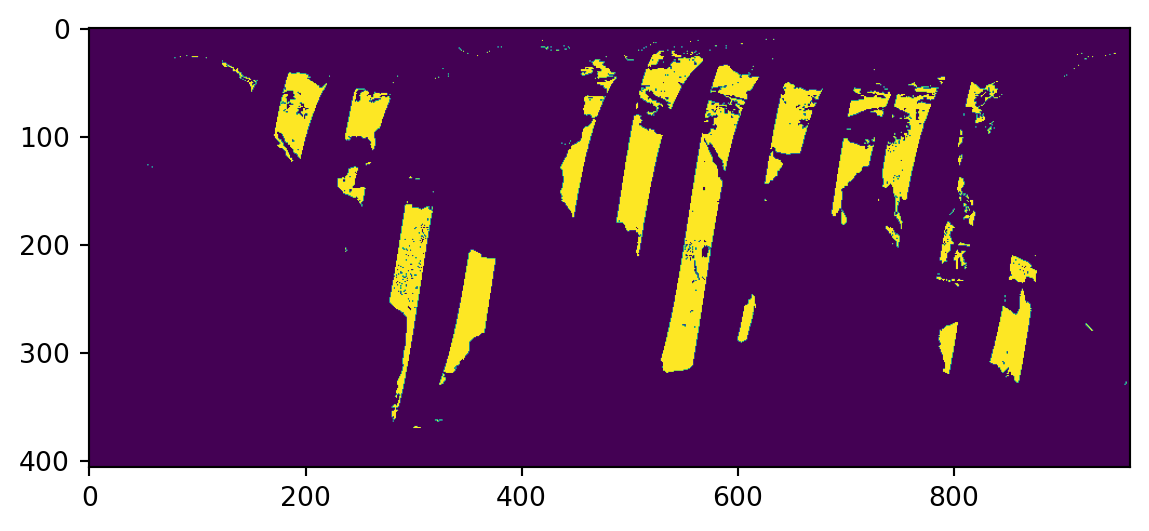

In [25]:
plt.imshow(data_vars['soil_moisture'][1])

In [26]:
data_vars['soil_moisture'][1].shape

(406, 964)

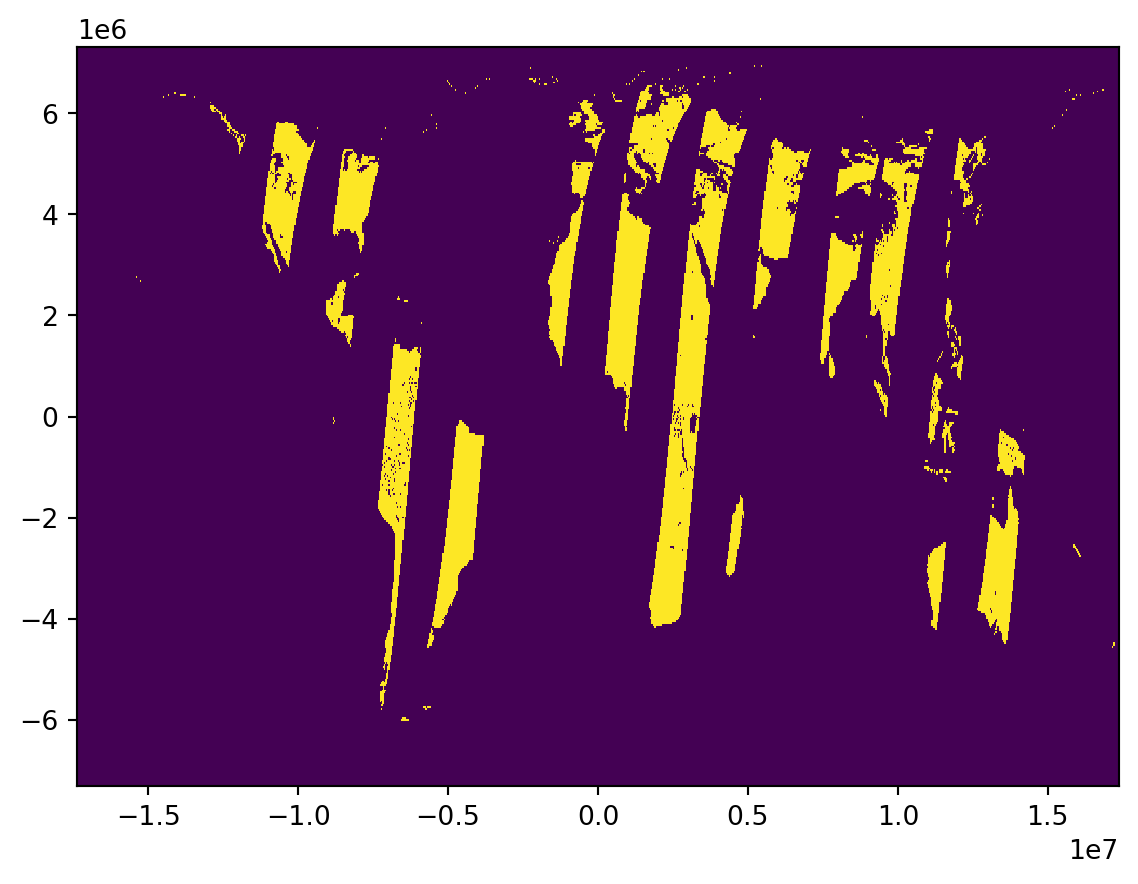

In [27]:
plt.pcolormesh(x, y, data_vars['soil_moisture'][1])

We also need to define the CRS.  We know that the CRS has the EPSG code 6933.  We can use `pyproj` to get the CRS definition.

Base on [CF-Conventions](http://cfconventions.org/cf-conventions/cf-conventions.html#grid-mappings-and-projections), we add the CRS as a variable with the same name as we used for the `grid_mapping` attribute of each data variable.  We define this variable as an integer.  The grid mapping information is then copied as attributes for that variable.  We use the `to_cf()` method of the `pyproj.CRS` object to do this.

In [28]:
ds = xr.Dataset(data_vars, coords={'x': x, 'y': y})
ds

<xarray.Dataset> Size: 2MB
Dimensions:              (y: 406, x: 964)
Coordinates:
  * x                    (x) float64 8kB -1.735e+07 -1.731e+07 ... 1.735e+07
  * y                    (y) float64 3kB 7.297e+06 7.26e+06 ... -7.297e+06
Data variables:
    soil_moisture        (y, x) float32 2MB -9.999e+03 -9.999e+03 ... -9.999e+03
    retrieval_qual_flag  (y, x) uint16 783kB 15 15 15 15 15 ... 15 15 15 15 15

In [29]:
ds.rio.write_crs(6933, inplace=True)

#ds[grid_mapping_name].attrs = crs.to_cf()

<xarray.Dataset> Size: 2MB
Dimensions:                          (y: 406, x: 964)
Coordinates:
  * x                                (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                                (y) float64 3kB 7.297e+06 ... -7.297e+06
    WGS84_NSIDC_EASEGrid_2.0_Global  int64 8B 0
Data variables:
    soil_moisture                    (y, x) float32 2MB -9.999e+03 ... -9.999...
    retrieval_qual_flag              (y, x) uint16 783kB 15 15 15 ... 15 15 15

In [30]:
ds =xr.decode_cf(ds)

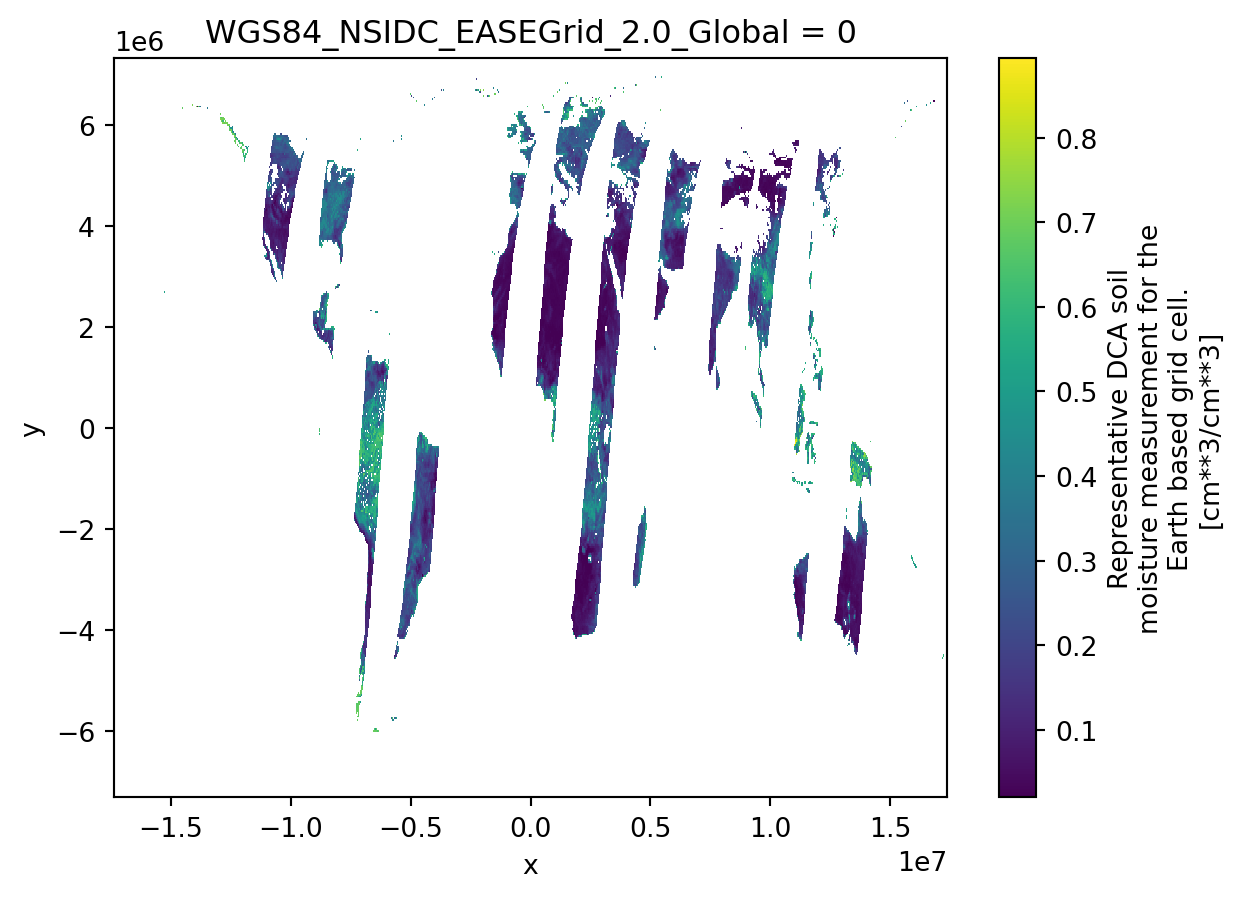

In [31]:
ds.soil_moisture.plot()